# Aplicação de *Bayesian Changepoint Detection* em Sistemas auto adaptativos
Bernardo Pandolfi Costa (19207646)

## Importações iniciais e instanciando variáveis:

In [14]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## *Background*

### *Changepoint*
Primeiramente, precisamos entender o que é um ponto de mudança (changepoint). Pontos de mudança são alterações abrúptas em dados de uma série temporal. Isso é facilmente visualizável através de gráficos, onde um conjunto de dados parece ser homogêneo e de uma hora para outra passa a apresentar valores diferentes.

A área de estudo de pontos de mudança possui diversas aplicações, como em finanças, predição de clima, biometrias e robótica. No contexto deste trabalho, tentarei aplicar a técnica de detecção de pontos de mudança Bayesiano para encontrar os momentos em que o sistema altera seu comportamento bruscamente, possivelmente necessitando uma reconfiguração da composição atual.

### Detecção *Offline* e *Online* de Pontos de Mudança
Existem diferentes métodos em algoritmos de detecção de pontos de mudança. A metodologia *Offline* faz a análise de todos os dados de um *dataset* completo, analisando retroativamente cada ponto para detectar onde ocorrem as mudanças de estado.

A detecção *Online*, por outro lado, tenta detectar os pontos de mudança em tempo real, então à medida que novos dados chegam, ele calcula a probabilidade daquele ponto, baseado em seu valor, ser um ponto de mudança de estado.

### Detecção de Pontos de Mudança Bayesiana *Online*
Pense em uma sequência de dados, como o preço de uma ação ao longo do tempo. Se o preço de repente mudar de um comportamento de estabilidade para uma queda acentuada, esse momento em que o comportamento mudou é o que chamamos de ponto de mudança. A **detecção bayesiana de pontos de mudança** é uma técnica que usa a probabilidade para tentar detectar esses momentos à medida que os dados chegam.

A detecção "bayesiana" usa a **Teoria de Bayes**, que nos permite calcular uma nova "crença" sobre onde os pontos de mudança estão conforme novos dados são observados. Ou seja, começamos com uma ideia inicial de onde podem estar os pontos de mudança e vamos atualizando essa ideia à medida que observamos mais dados.

#### Como o Algoritmo Funciona Passo a Passo?

Aqui está um resumo simplificado de como o algoritmo descrito no artigo funciona:

1. **Iniciar o Algoritmo**: Começamos supondo que o run length é zero ($r_t=0$), ou seja, acreditamos que o primeiro ponto de dados é o início de uma nova sequência sem pontos de mudança.
   
2. **Observar um Novo Dado**: Quando um novo ponto de dado chega, fazemos uma previsão de como ele deveria se comportar com base no comportamento observado até agora.
   
3. **Atualizar a Probabilidade de Crescimento**: Com base no padrão de comportamento do conjunto de dados de $r_t$, calculamos a probabilidade de que o novo dado siga o mesmo padrão (ou seja, não houve ponto de mudança).

4. **Atualizar a Probabilidade de Mudança**: Calculamos a probabilidade de que o novo dado represente o início de um novo padrão (ou seja, um ponto de mudança acabou de ocorrer).

5. **Atualizar as Crenças**: Com base nessas probabilidades, atualizamos nossa crença sobre qual é o run length atual.

6. **Repetir**: Continuamos fazendo isso a cada novo dado observado.
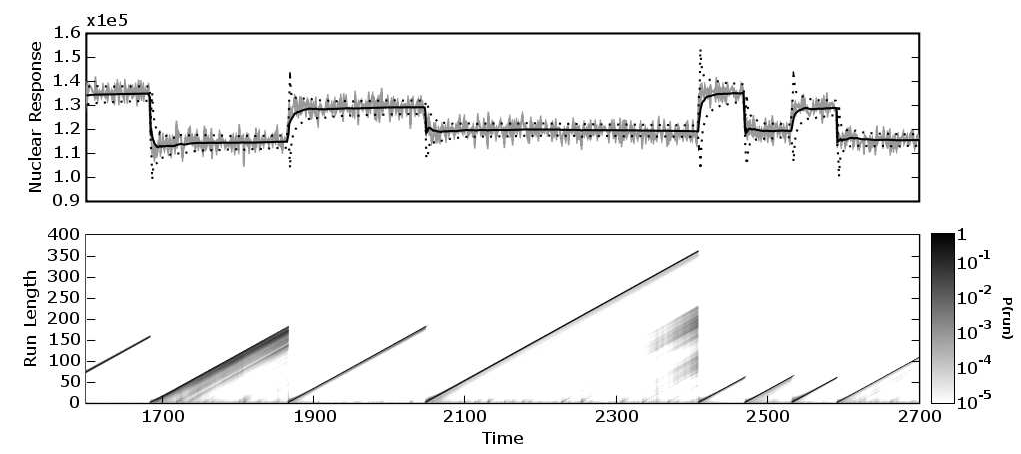

#### Função de Risco (*Hazard Function*)
A função de risco, ou **hazard function**, é mais um parâmetro do cálculo das probabilidades de mudança. Ela basicamente determina com que frequência esperamos que um ponto de mudança ocorra. Por exemplo, se você acredita que mudanças acontecem de forma muito frequente, a função de risco será alta, e o algoritmo vai estar mais "alerta" a possíveis mudanças.

Se você assumir que os pontos de mudança são raros (ou seja, a função de risco é baixa), o algoritmo vai preferir seguir com o padrão atual por mais tempo antes de "suspeitar" de uma mudança.

#### Cálculo da Probabilidade Preditiva

O objetivo final do algoritmo é sempre ser capaz de fazer uma previsão do próximo valor que será observado, dado o que já sabemos até agora. Para isso, o algoritmo calcula a **distribuição preditiva**:
$$
P(x_{t+1} | x_{1:t}) = \sum_{r_t} P(x_{t+1} | r_t, x_{(r_t)}) P(r_t | x_{1:t})
$$
Essa equação diz que a previsão do próximo dado $ x_{t+1} $ depende de todas as hipóteses possíveis sobre o run length e do que já observamos até agora.

### O que é Detecção de Pontos de Mudança Bayesiana "Offline"?
Na abordagem **offline**, o objetivo ainda é detectar pontos em uma sequência de dados onde há uma mudança no comportamento (como na média ou na variância). A diferença é que agora você tem todos os dados disponíveis desde o início, então a técnica pode ser mais sofisticada e usar a informação completa para identificar os pontos de mudança **de forma retrospectiva**.

Pense em uma sequência de dados históricos, como a temperatura registrada ao longo dos anos. Se houver um período onde a média da temperatura subitamente muda, o objetivo da detecção de pontos de mudança **offline** é encontrar esses momentos de mudança com o benefício de poder "olhar para trás" e analisar o comportamento global dos dados.

#### Como o Algoritmo Funciona?

1. **Inicialização**: Você começa assumindo que não sabe onde os pontos de mudança estão. Sua **a priori** pode ser que mudanças sejam raras ou que ocorram em intervalos regulares.

2. **Divisão da Sequência**: O algoritmo explora todas as maneiras possíveis de dividir os dados em diferentes segmentos. Para cada divisão possível, ele calcula a verossimilhança de que aquela divisão explica os dados corretamente.

3. **Cálculo da Verossimilhança**: Para cada divisão, você calcula a verossimilhança. Por exemplo, se você supõe que há um ponto de mudança no meio da sequência, você calcula o quão bem os dados antes e depois desse ponto se ajustam às distribuições modeladas.

4. **Aplicação de Bayes**: Usando o Teorema de Bayes, você combina a verossimilhança observada com sua distribuição a priori e calcula a distribuição posterior, que é a probabilidade de que um ponto de mudança tenha ocorrido em cada ponto da sequência.

5. **Identificação dos Pontos de Mudança**: Após calcular a distribuição posterior para todos os pontos da sequência, o algoritmo identifica os pontos onde a probabilidade de mudança é mais alta. Esses são os pontos onde é mais provável que uma mudança nos dados tenha ocorrido.

6. **Refinamento**: Se houver incerteza sobre onde exatamente a mudança ocorreu (por exemplo, se a mudança foi gradual), o algoritmo pode refinar sua estimativa iterativamente.

## Aplicação dos Algoritmos: Datasets Utilizados
Neste trabalho, serão aplicados os algoritmos de detecção de pontos de mudança Bayesiano em alguns diferentes casos, tanto no formato online quanto no offline. Começaremos com dois exemplos mais claros, cada um com um total de 400 requisições, 100 para cada configuração do sistema. O objetivo da aplicação do algoritmo Bayesiano é detectar os pontos em que houve a alteração na composição do Distributor, como por exemplo mudando do Local para o Sharding.

### Primeiro Dataset: 2 Itens

O primeiro Dataset grava o comportamento do sistema com a lista de tamanho 2. O sistema inicia na composição `propagate`, e alterna entre as outras composições no decorrer do experimento.

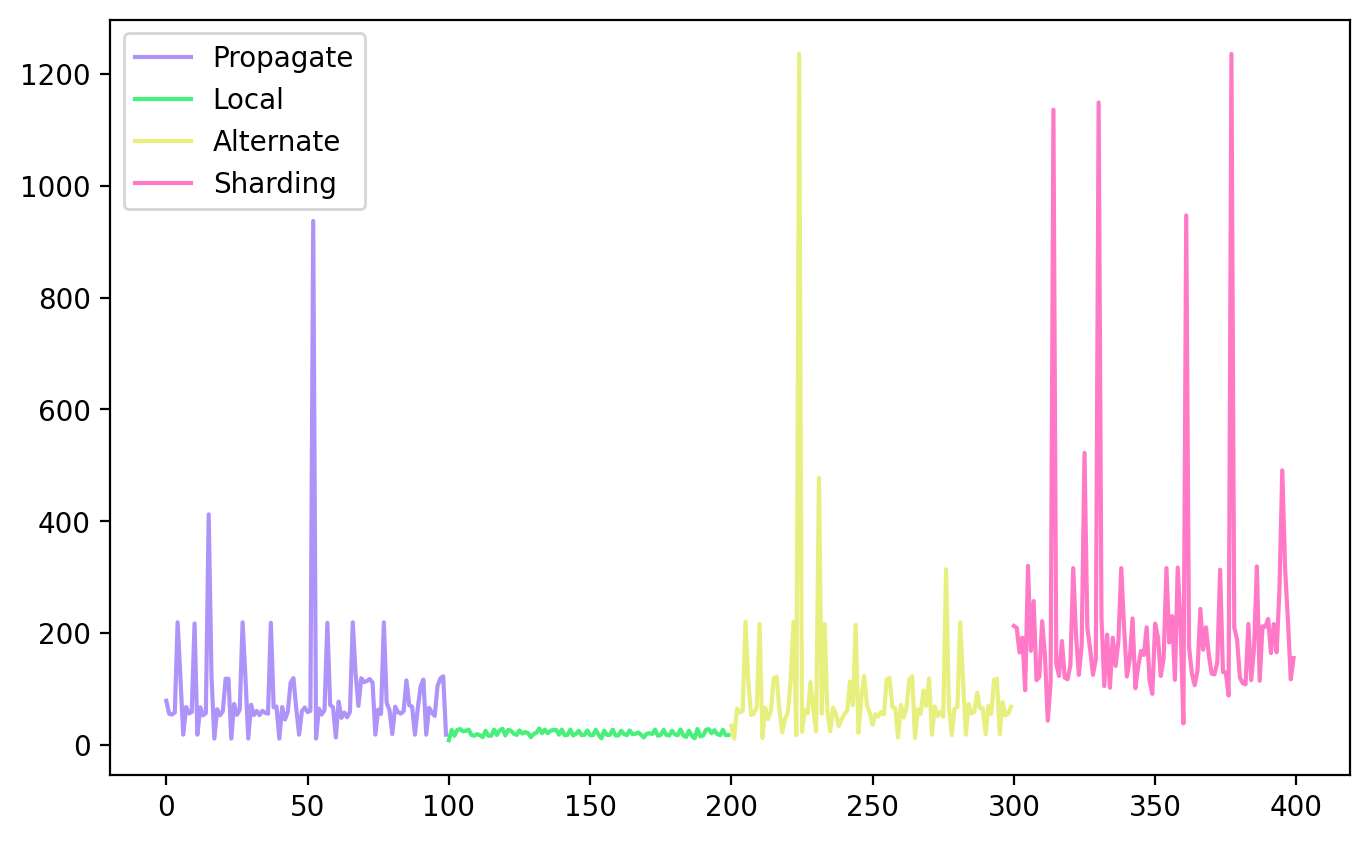

In [15]:
df1 = pd.read_csv('./data/propagate2itens.csv')
df2 = pd.read_csv('./data/local2itens.csv')
df3 = pd.read_csv('./data/alternate2itens.csv')
df4 = pd.read_csv('./data/sharding2itens.csv')

current_action_time_df1 = df1[df1['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time_df2 = df2[df2['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time_df3 = df3[df3['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time_df4 = df4[df4['Series'] == 'Current Action Time'].iloc[:, 2].values

combined_current_action_time = np.concatenate((
    current_action_time_df1, 
    current_action_time_df2, 
    current_action_time_df3, 
    current_action_time_df4
))

indices_df1 = np.arange(len(current_action_time_df1))
indices_df2 = np.arange(len(current_action_time_df1), len(current_action_time_df1) + len(current_action_time_df2))
indices_df3 = np.arange(len(current_action_time_df1) + len(current_action_time_df2), len(current_action_time_df1) + len(current_action_time_df2) + len(current_action_time_df3))
indices_df4 = np.arange(len(current_action_time_df1) + len(current_action_time_df2) + len(current_action_time_df3), len(combined_current_action_time))

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(indices_df1, current_action_time_df1, label='Propagate', color="#ae93f9")
plt.plot(indices_df2, current_action_time_df2, label='Local', color="#48f07b")
plt.plot(indices_df3, current_action_time_df3, label='Alternate', color="#e7f07e")
plt.plot(indices_df4, current_action_time_df4, label='Sharding', color="#ff79c6")

plt.legend()

plt.show()


Em casos como este, é fácil visualizar a mudança de estados, já que existe um salto considerável entre o tempo de resposta na alteração da composição.

### Segundo Dataset: 36 Itens

O segundo dataset considera uma lista de tamanho 36. O processo aqui é o mesmo, o sistema inicia em uma configuração e a cada 100 iterações ele altera o estado.

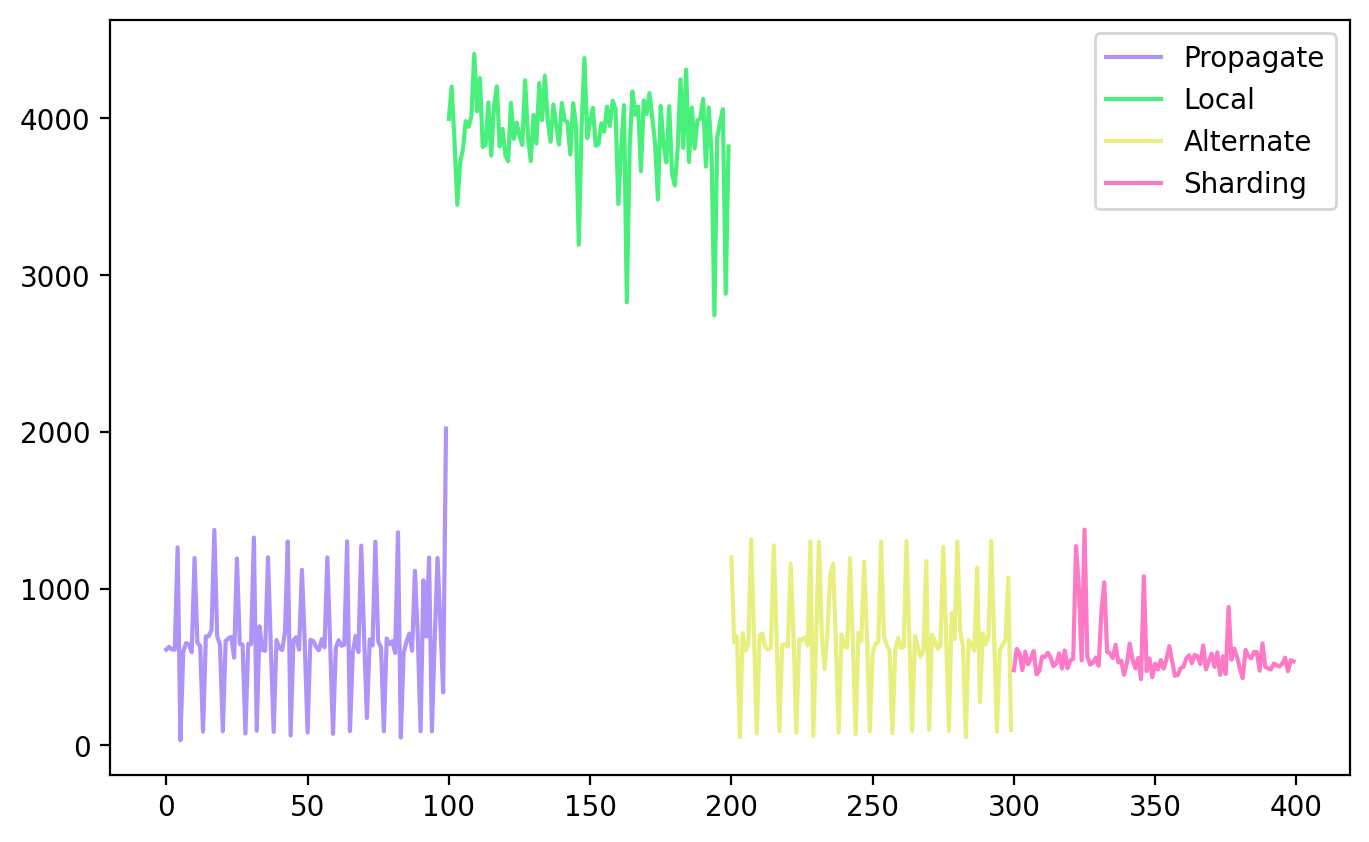

In [16]:
df36_1 = pd.read_csv('./data/propagate36itens.csv')
df36_2 = pd.read_csv('./data/local36itens.csv')
df36_3 = pd.read_csv('./data/alternate36itens.csv')
df36_4 = pd.read_csv('./data/sharding36itens.csv')

current_action_time36_df1 = df36_1[df36_1['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time36_df2 = df36_2[df36_2['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time36_df3 = df36_3[df36_3['Series'] == 'Current Action Time'].iloc[:, 2].values
current_action_time36_df4 = df36_4[df36_4['Series'] == 'Current Action Time'].iloc[:, 2].values

combined_current_action_time36 = np.concatenate((
    current_action_time36_df1, 
    current_action_time36_df2, 
    current_action_time36_df3, 
    current_action_time36_df4
))

indices_df1 = np.arange(len(current_action_time36_df1))
indices_df2 = np.arange(len(current_action_time36_df1), len(current_action_time36_df1) + len(current_action_time36_df2))
indices_df3 = np.arange(len(current_action_time36_df1) + len(current_action_time36_df2), len(current_action_time36_df1) + len(current_action_time36_df2) + len(current_action_time36_df3))
indices_df4 = np.arange(len(current_action_time36_df1) + len(current_action_time36_df2) + len(current_action_time36_df3), len(combined_current_action_time36))

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(indices_df1, current_action_time36_df1, label='Propagate', color="#ae93f9")
plt.plot(indices_df2, current_action_time36_df2, label='Local', color="#48f07b")
plt.plot(indices_df3, current_action_time36_df3, label='Alternate', color="#e7f07e")
plt.plot(indices_df4, current_action_time36_df4, label='Sharding', color="#ff79c6")

plt.legend()

plt.show()


### Terceiro Dataset: Mudanças No decorrer do Dataset (Local)

Para este grupo de dados, foram feitas alterações no tamanho da lista para as ações Local e Sharding. Estes datasets simulam o sistema rodando em tempo real em que mudanças nas requisições acontecem de forma não linear.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


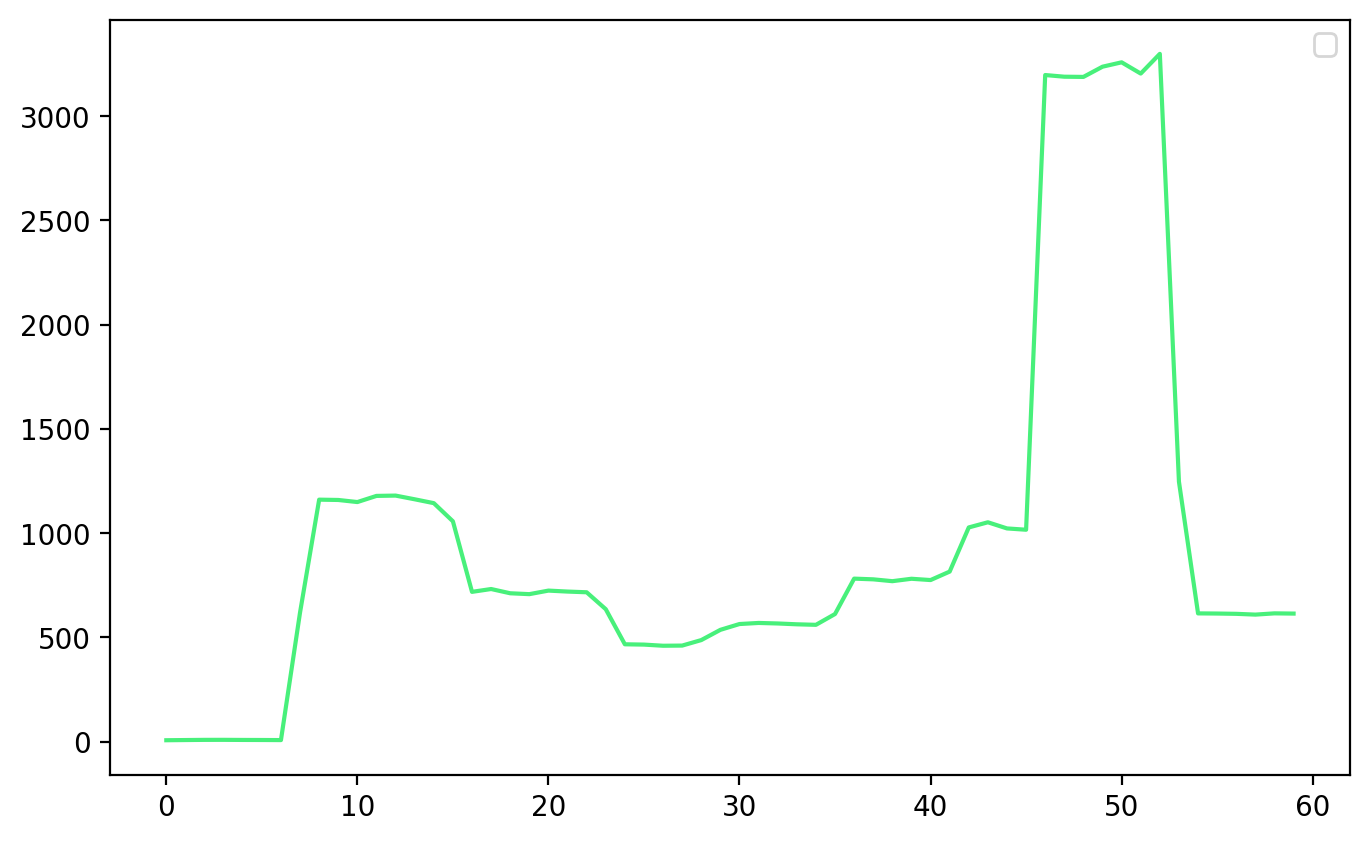

In [17]:
df_case3 = pd.read_csv('./data/changing_local.csv')

current_action_time_df_case3 = df_case3[df_case3['Series'] == 'Current Action Time'].iloc[:, 2].values

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(current_action_time_df_case3, color="#48f07b")

plt.legend()

plt.show()

### Quarto Dataset: Mudanças No decorrer do Dataset (Sharding)

Para este grupo de dados, foram feitas alterações no tamanho da lista para as ações Local e Sharding. Estes datasets simulam o sistema rodando em tempo real em que mudanças nas requisições acontecem de forma não linear.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


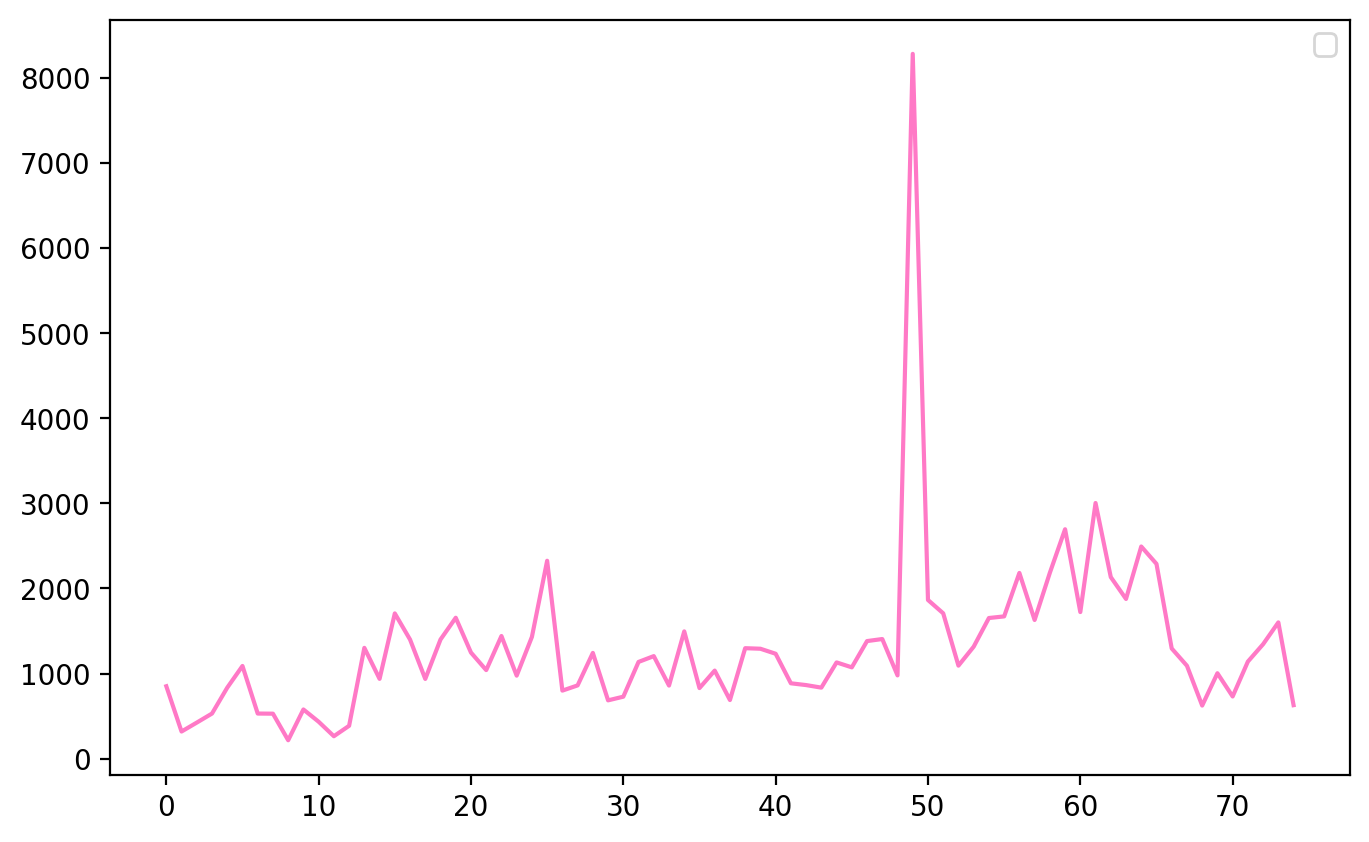

In [18]:
df_case4 = pd.read_csv('./data/changing_sharding.csv')

current_action_time_df_case4 = df_case4[df_case4['Series'] == 'Current Action Time'].iloc[:, 2].values

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(current_action_time_df_case4, color="#ff79c6")

plt.legend()

plt.show()

### Quinto Dataset
Este dataset analisa um caso em que dois agentes que tentam configurar automaticamente o sistema alternando entre as configurações Local e Sharding em um ambiente de crescida linear do tamanho de lista. A lista inicia com 2 elementos e aumenta indefinidamente.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


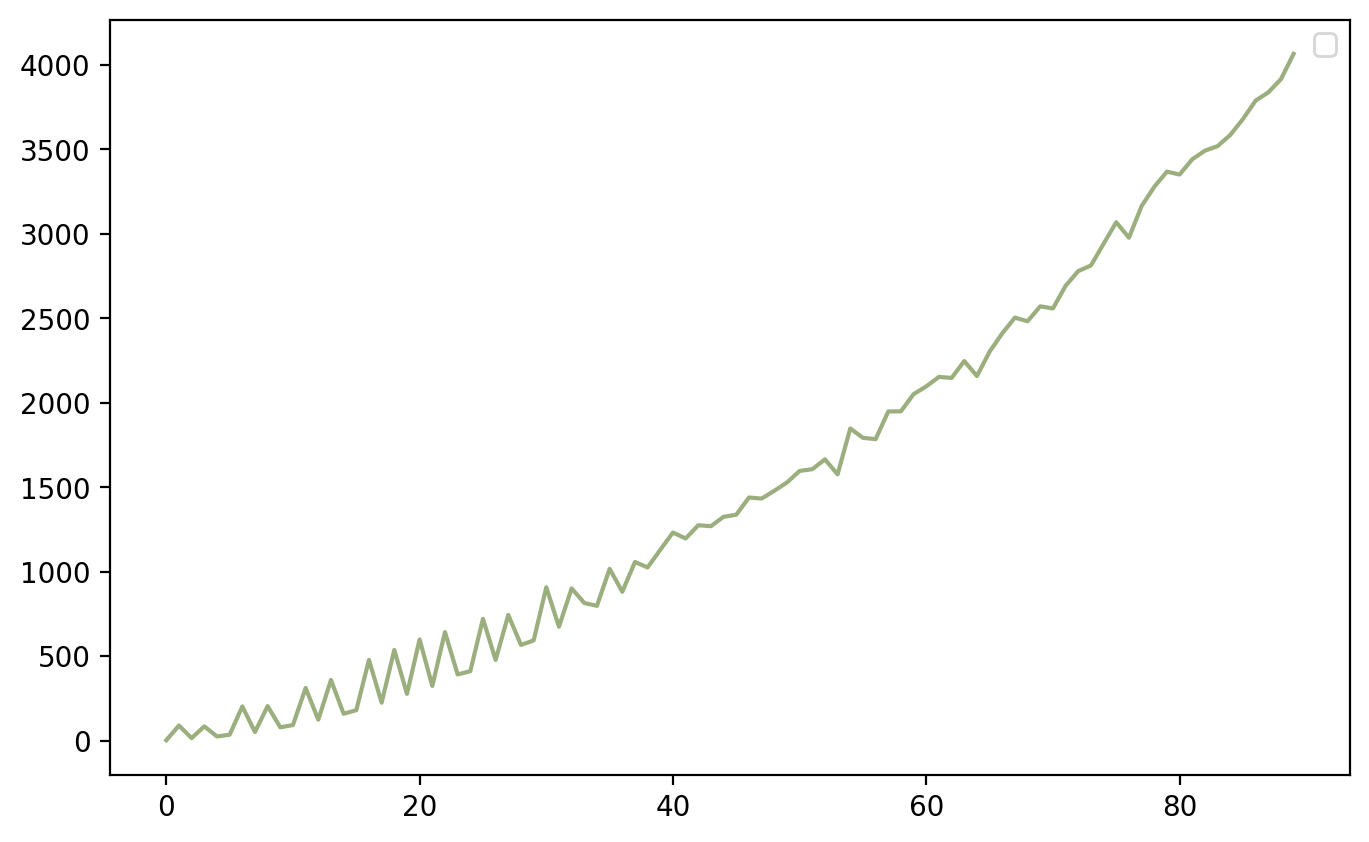

In [19]:
df_case5 = pd.read_csv('./data/agents5.csv')

current_action_time_df_case5 = df_case5[df_case5['Series'] == 'Current Action Time'].iloc[:, 2].values

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(current_action_time_df_case5, color="#9bae7e")

plt.legend()

plt.show()

### Sexto Dataset
Este dataset analisa o mesmo sistema do dataset anterior, porém neste caso, a lista diminui com o tempo, iniciando com 90 itens. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


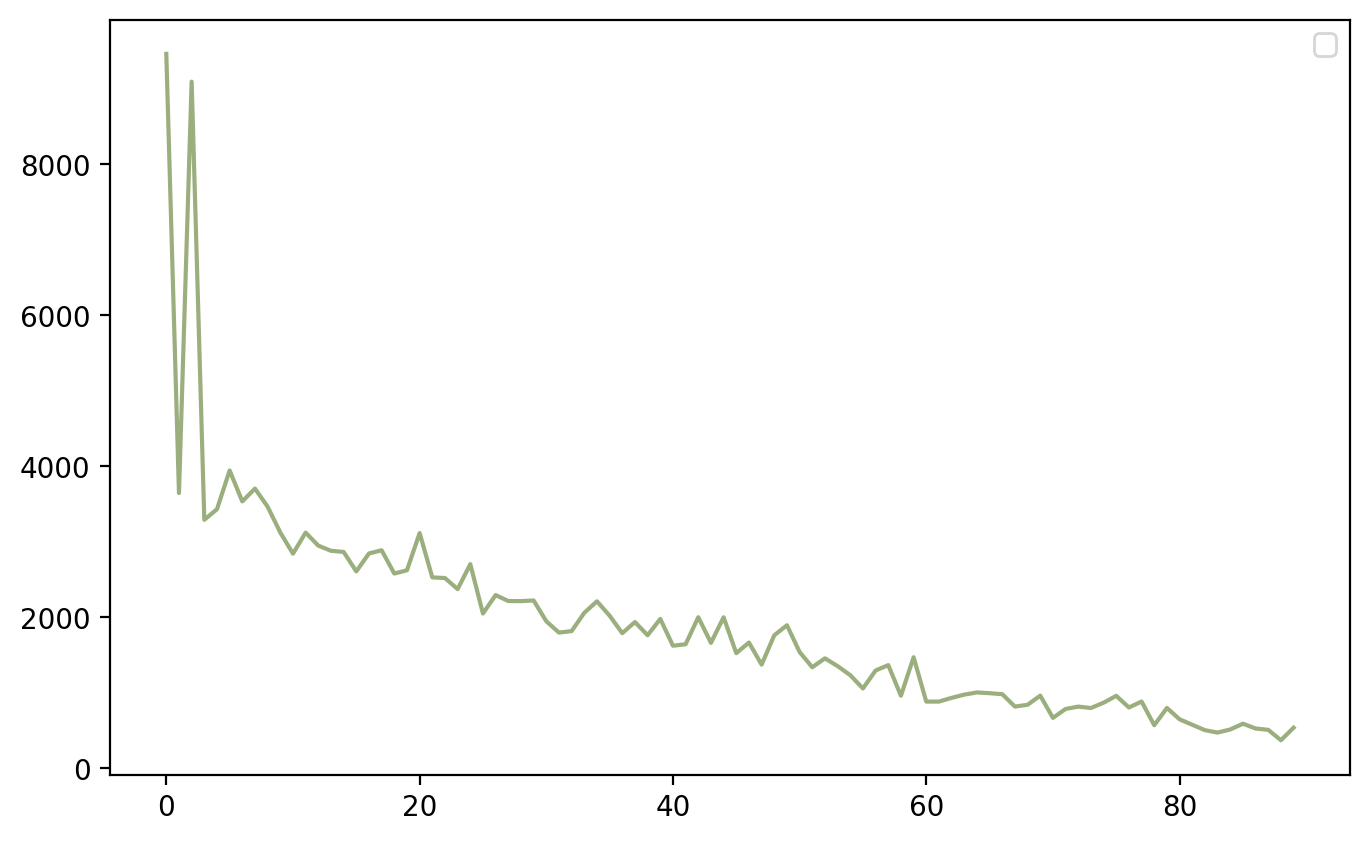

In [20]:
df_case6 = pd.read_csv('./data/agents6.csv')

current_action_time_df_case6 = df_case6[df_case6['Series'] == 'Current Action Time'].iloc[:, 2].values

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(current_action_time_df_case6, color="#9bae7e")

plt.legend()

plt.show()

## Aplicando o Algoritmo Bayesiano - Offline
### Caso 1

Use scipy logsumexp().


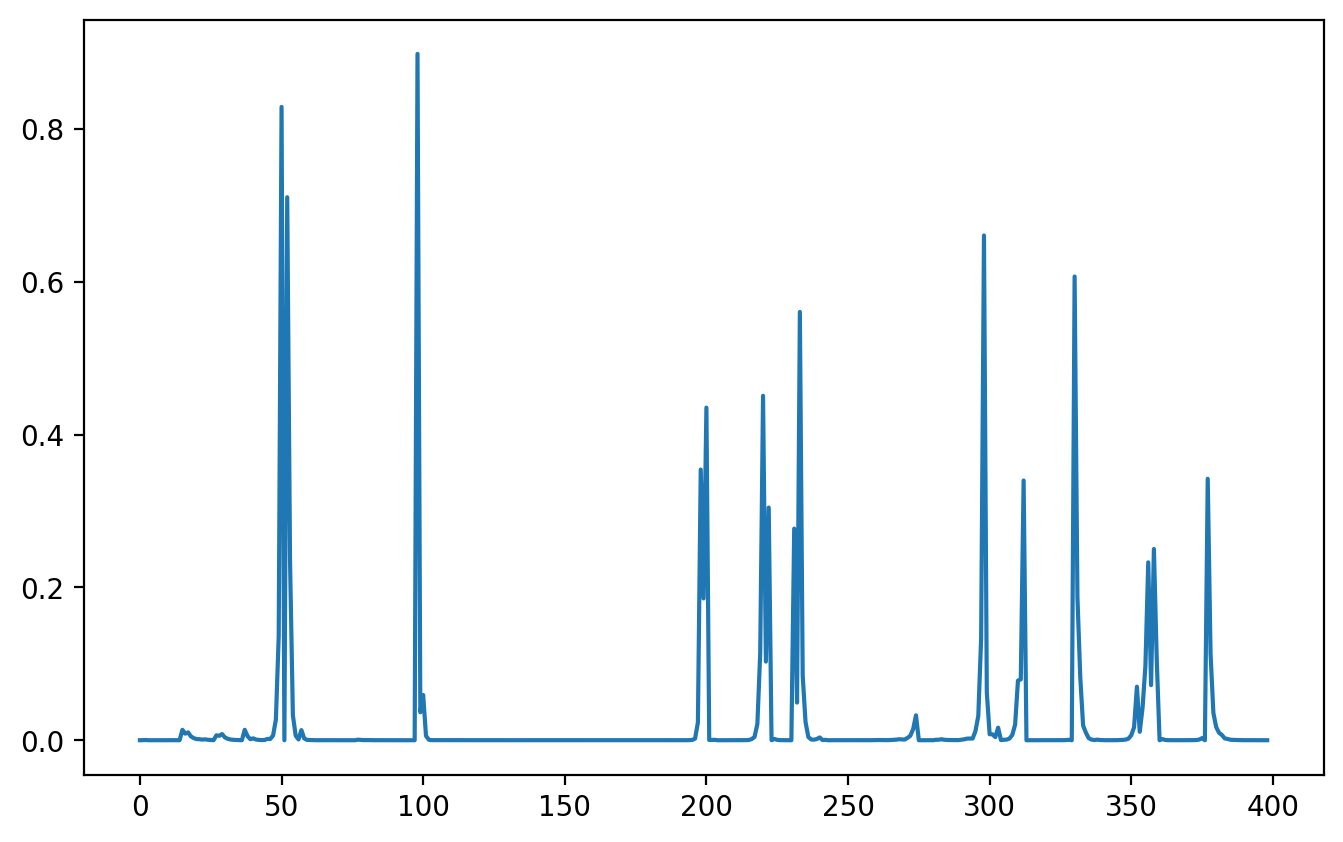

In [21]:
from bayesian_changepoint_detection.priors import const_prior
from functools import partial

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

prior_function = partial(const_prior, p=1/(len(combined_current_action_time) + 1))

Q, P, Pcp = offline_changepoint_detection(combined_current_action_time, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

### Caso 2

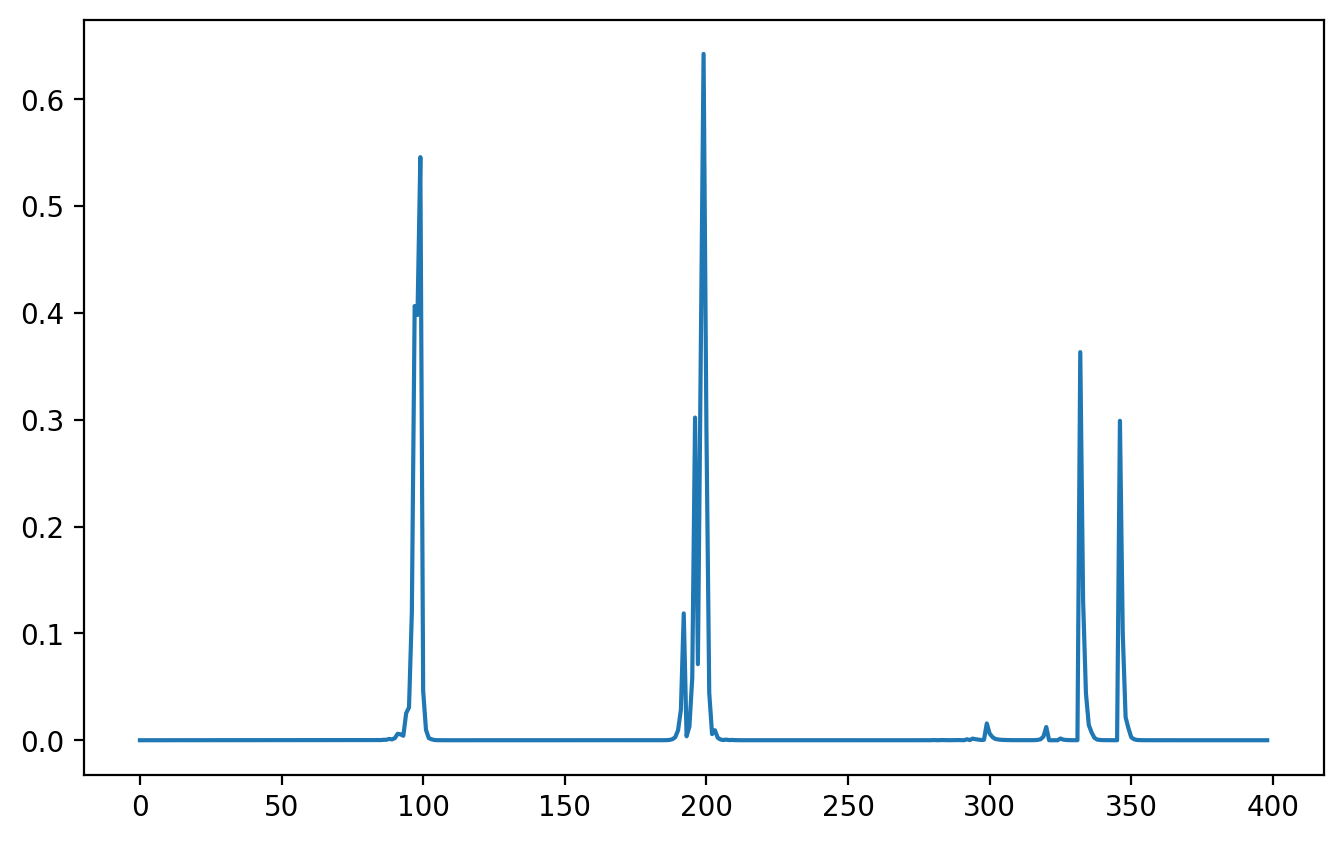

In [22]:
prior_function = partial(const_prior, p=1/(len(combined_current_action_time36) + 1))

Q, P, Pcp = offline_changepoint_detection(combined_current_action_time36, prior_function ,offline_ll.StudentT(),truncate=-40)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

### Caso 3

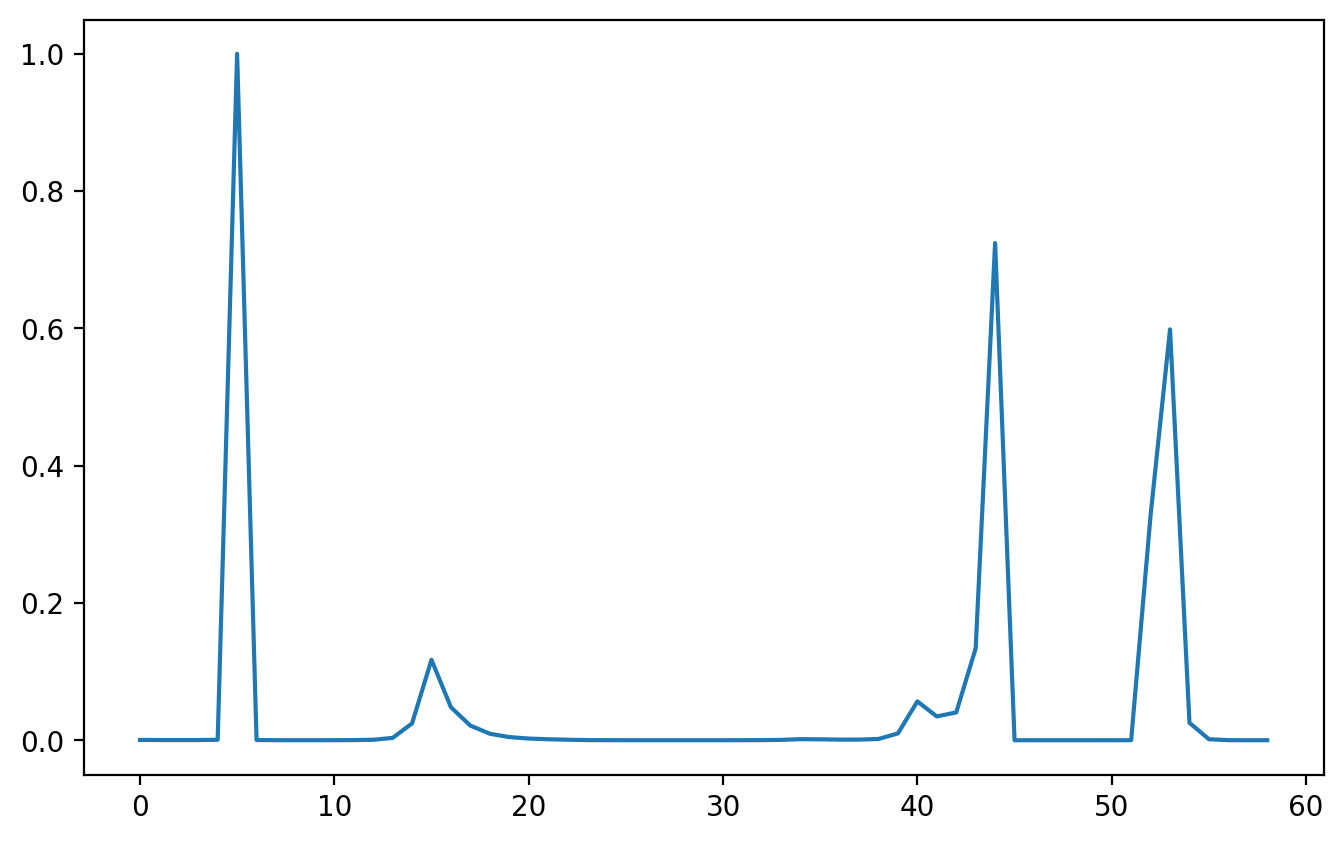

In [23]:
prior_function = partial(const_prior, p=1/(len(current_action_time_df_case3) + 1))

Q, P, Pcp = offline_changepoint_detection(current_action_time_df_case3, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

### Caso 4

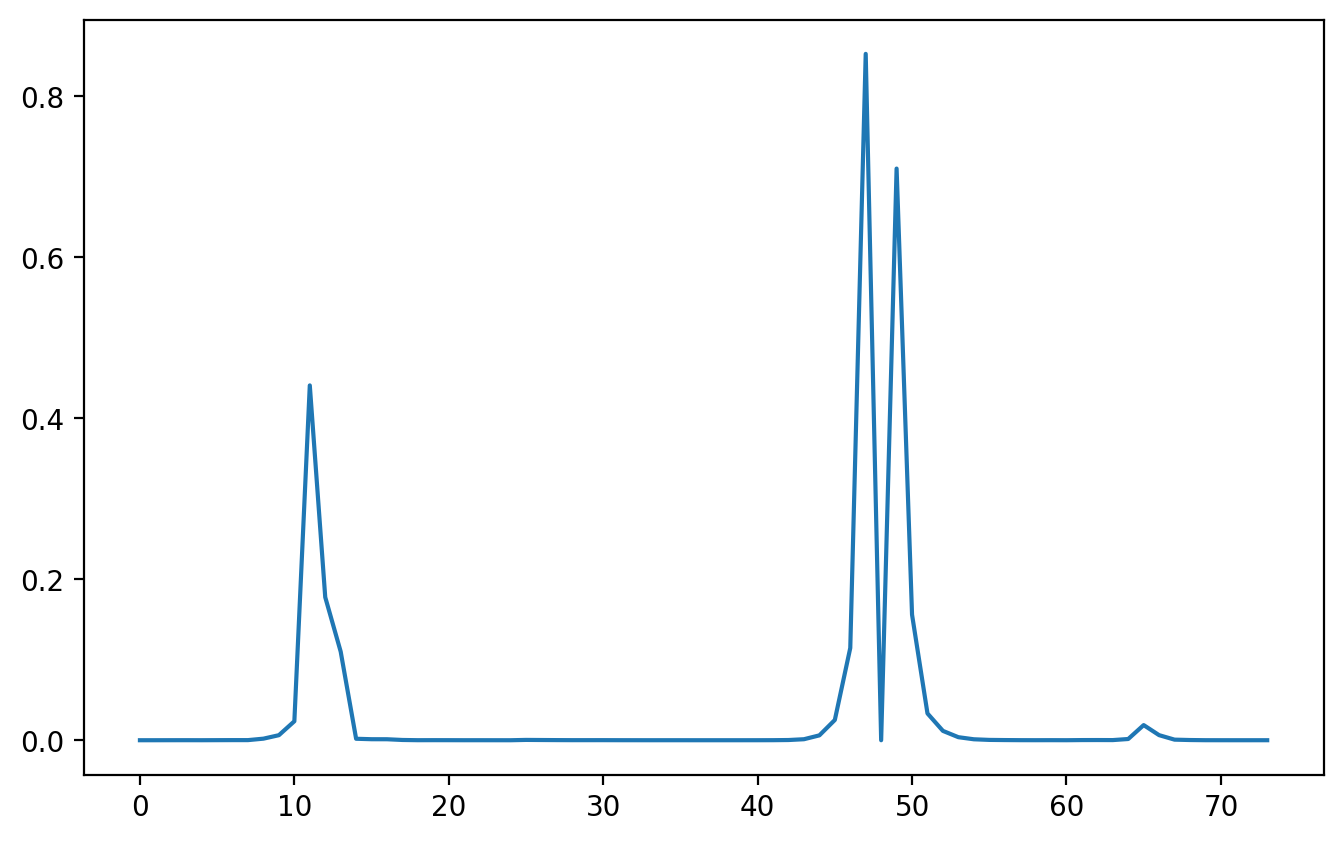

In [24]:
prior_function = partial(const_prior, p=1/(len(current_action_time_df_case4) + 1))

Q, P, Pcp = offline_changepoint_detection(current_action_time_df_case4, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

### Caso 5

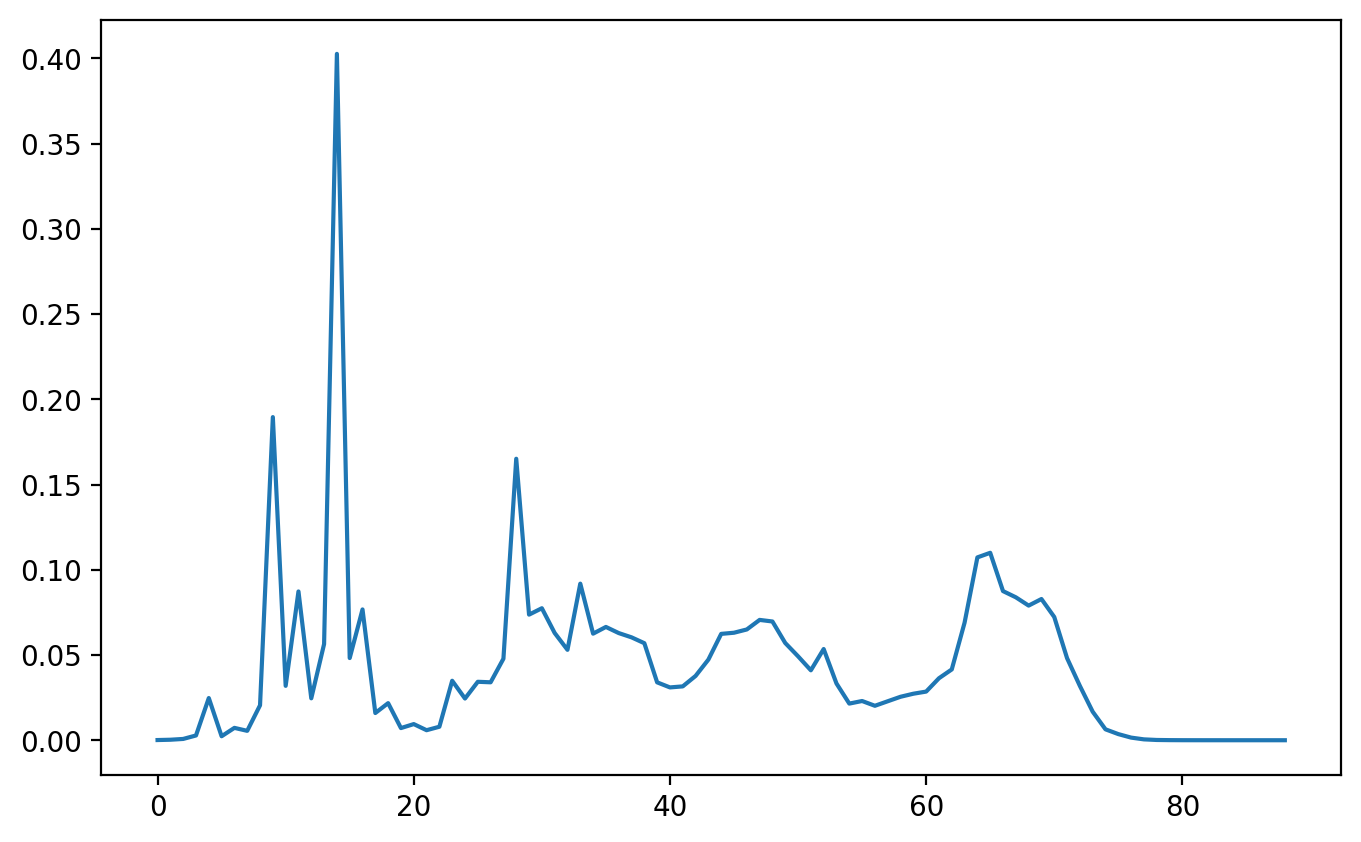

In [25]:
prior_function = partial(const_prior, p=1/(len(current_action_time_df_case5) + 1))

Q, P, Pcp = offline_changepoint_detection(current_action_time_df_case5, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

### Caso 6

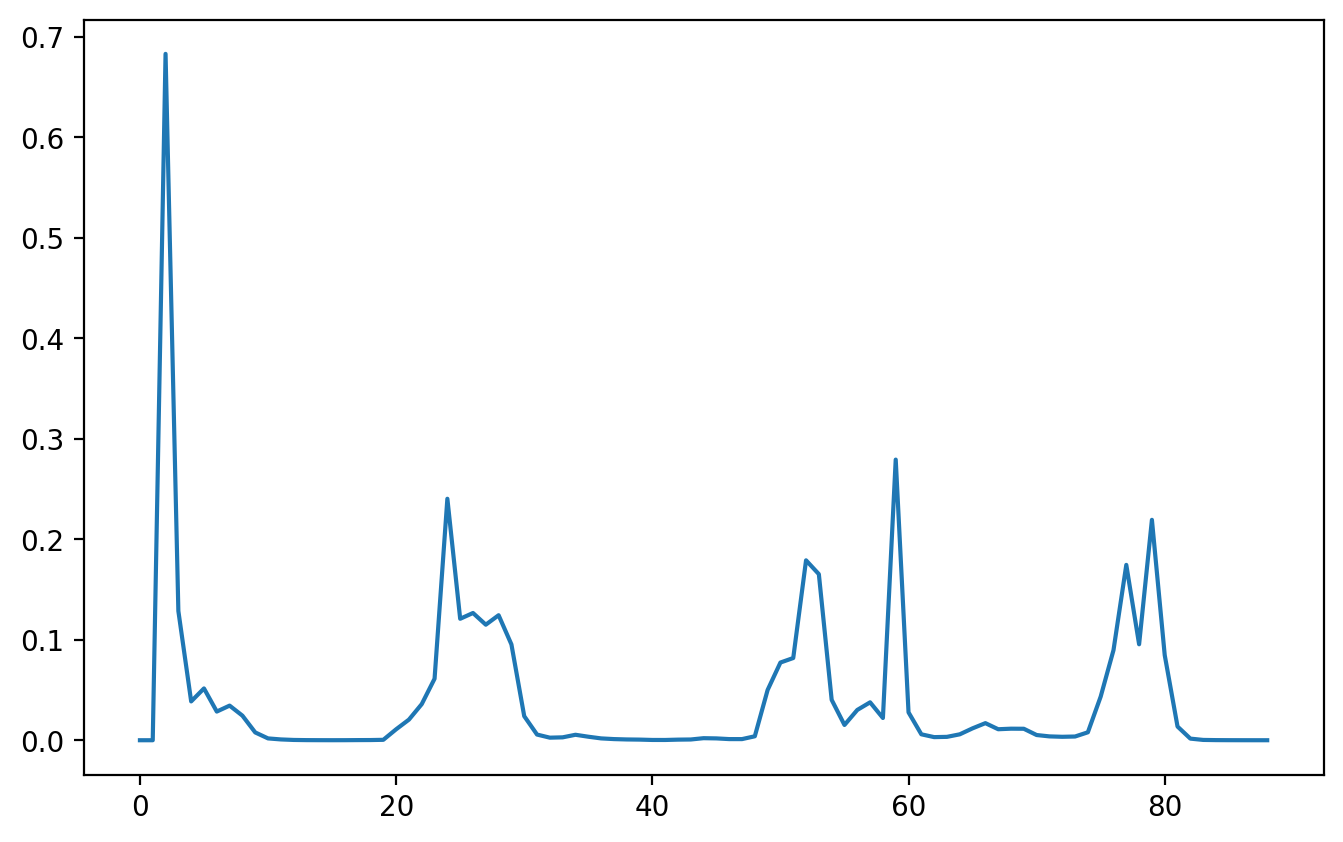

In [26]:
prior_function = partial(const_prior, p=1/(len(current_action_time_df_case6) + 1))

Q, P, Pcp = offline_changepoint_detection(current_action_time_df_case6, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=200)
plt.plot(np.exp(Pcp).sum(0))

## Aplicando o Algoritmo Bayesiano - Online

Para a aplicação Online, dois gráficos são gerados. Um deles mostra apenas a probabilidade de um ponto de mudança ter ocorrido (gráfico de linha em azul), e outro que apresenta, em escala logarítmica de cor, a probabilidade posterior do *run length* atual e verticalmente o tamanho do $r_t$. Preto equivale a 0 e branco equivale a uma probabilidade de 1.

### Caso 1

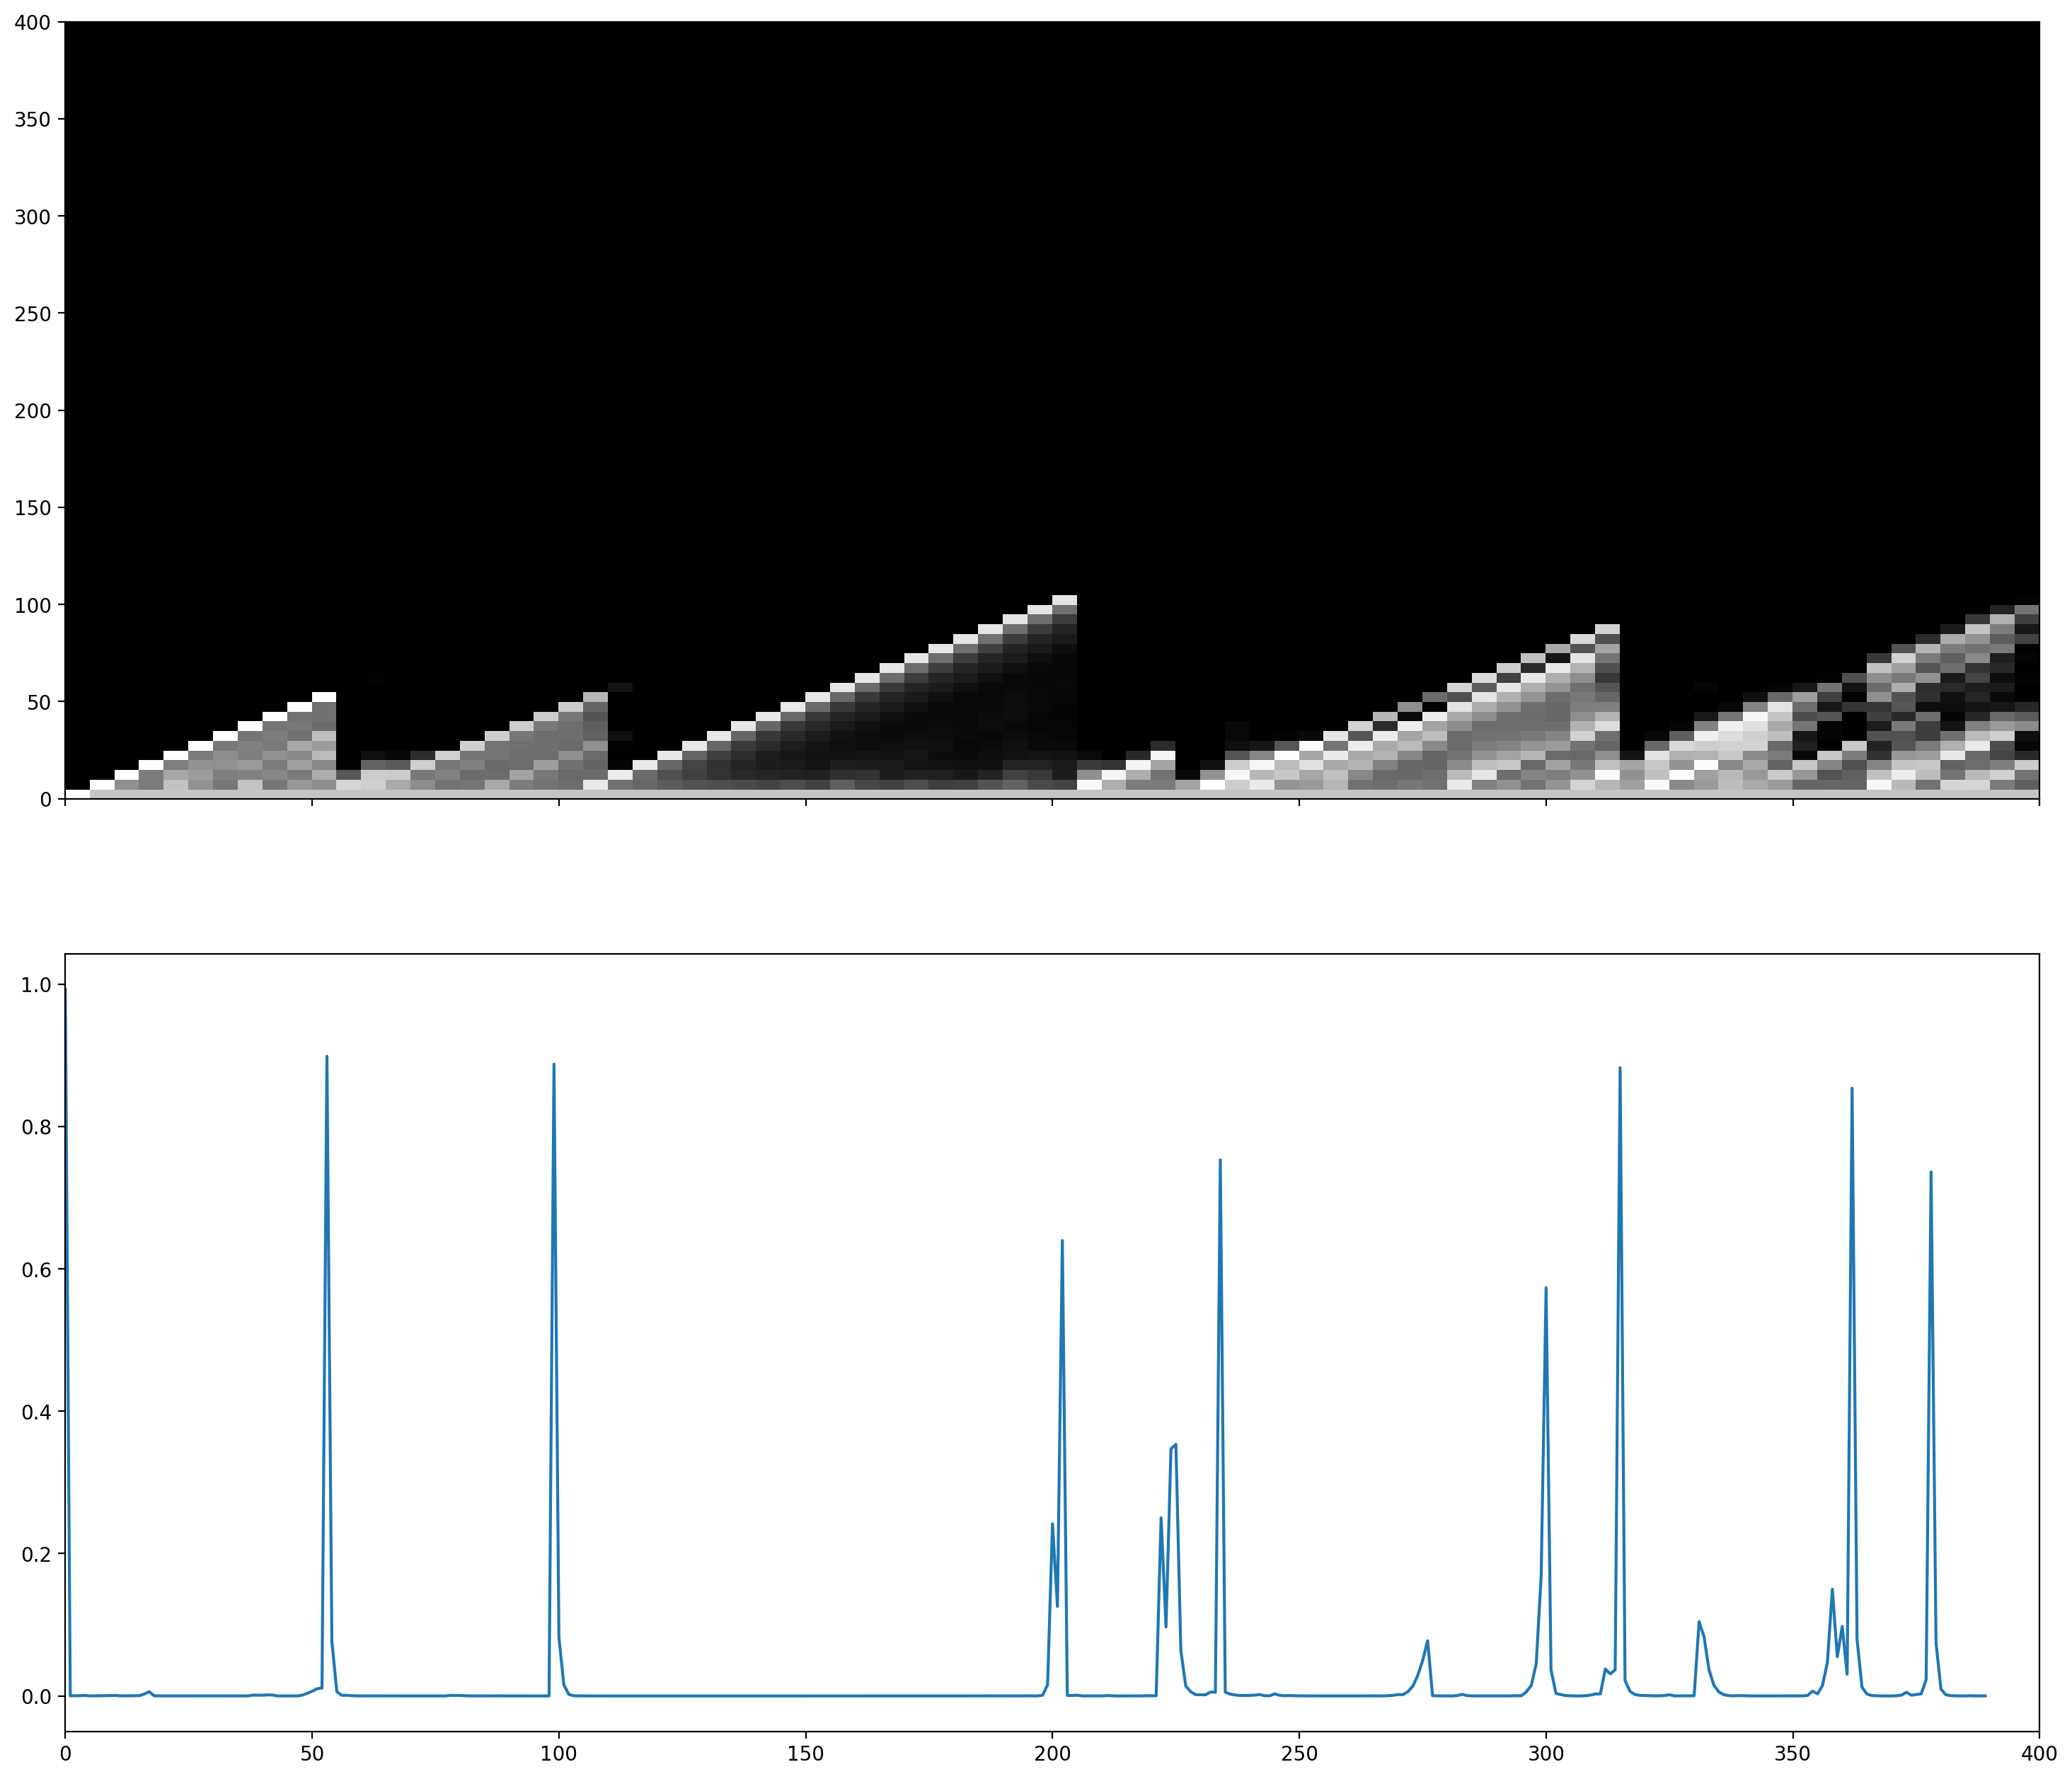

In [27]:
from bayesian_changepoint_detection.hazard_functions import constant_hazard
hazard_function = partial(constant_hazard, 250)

from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll
import matplotlib.cm as cm

R, maxes = online_changepoint_detection(
    combined_current_action_time, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True, dpi=200)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[1].plot(R[Nw,Nw:-1])

### Caso 2

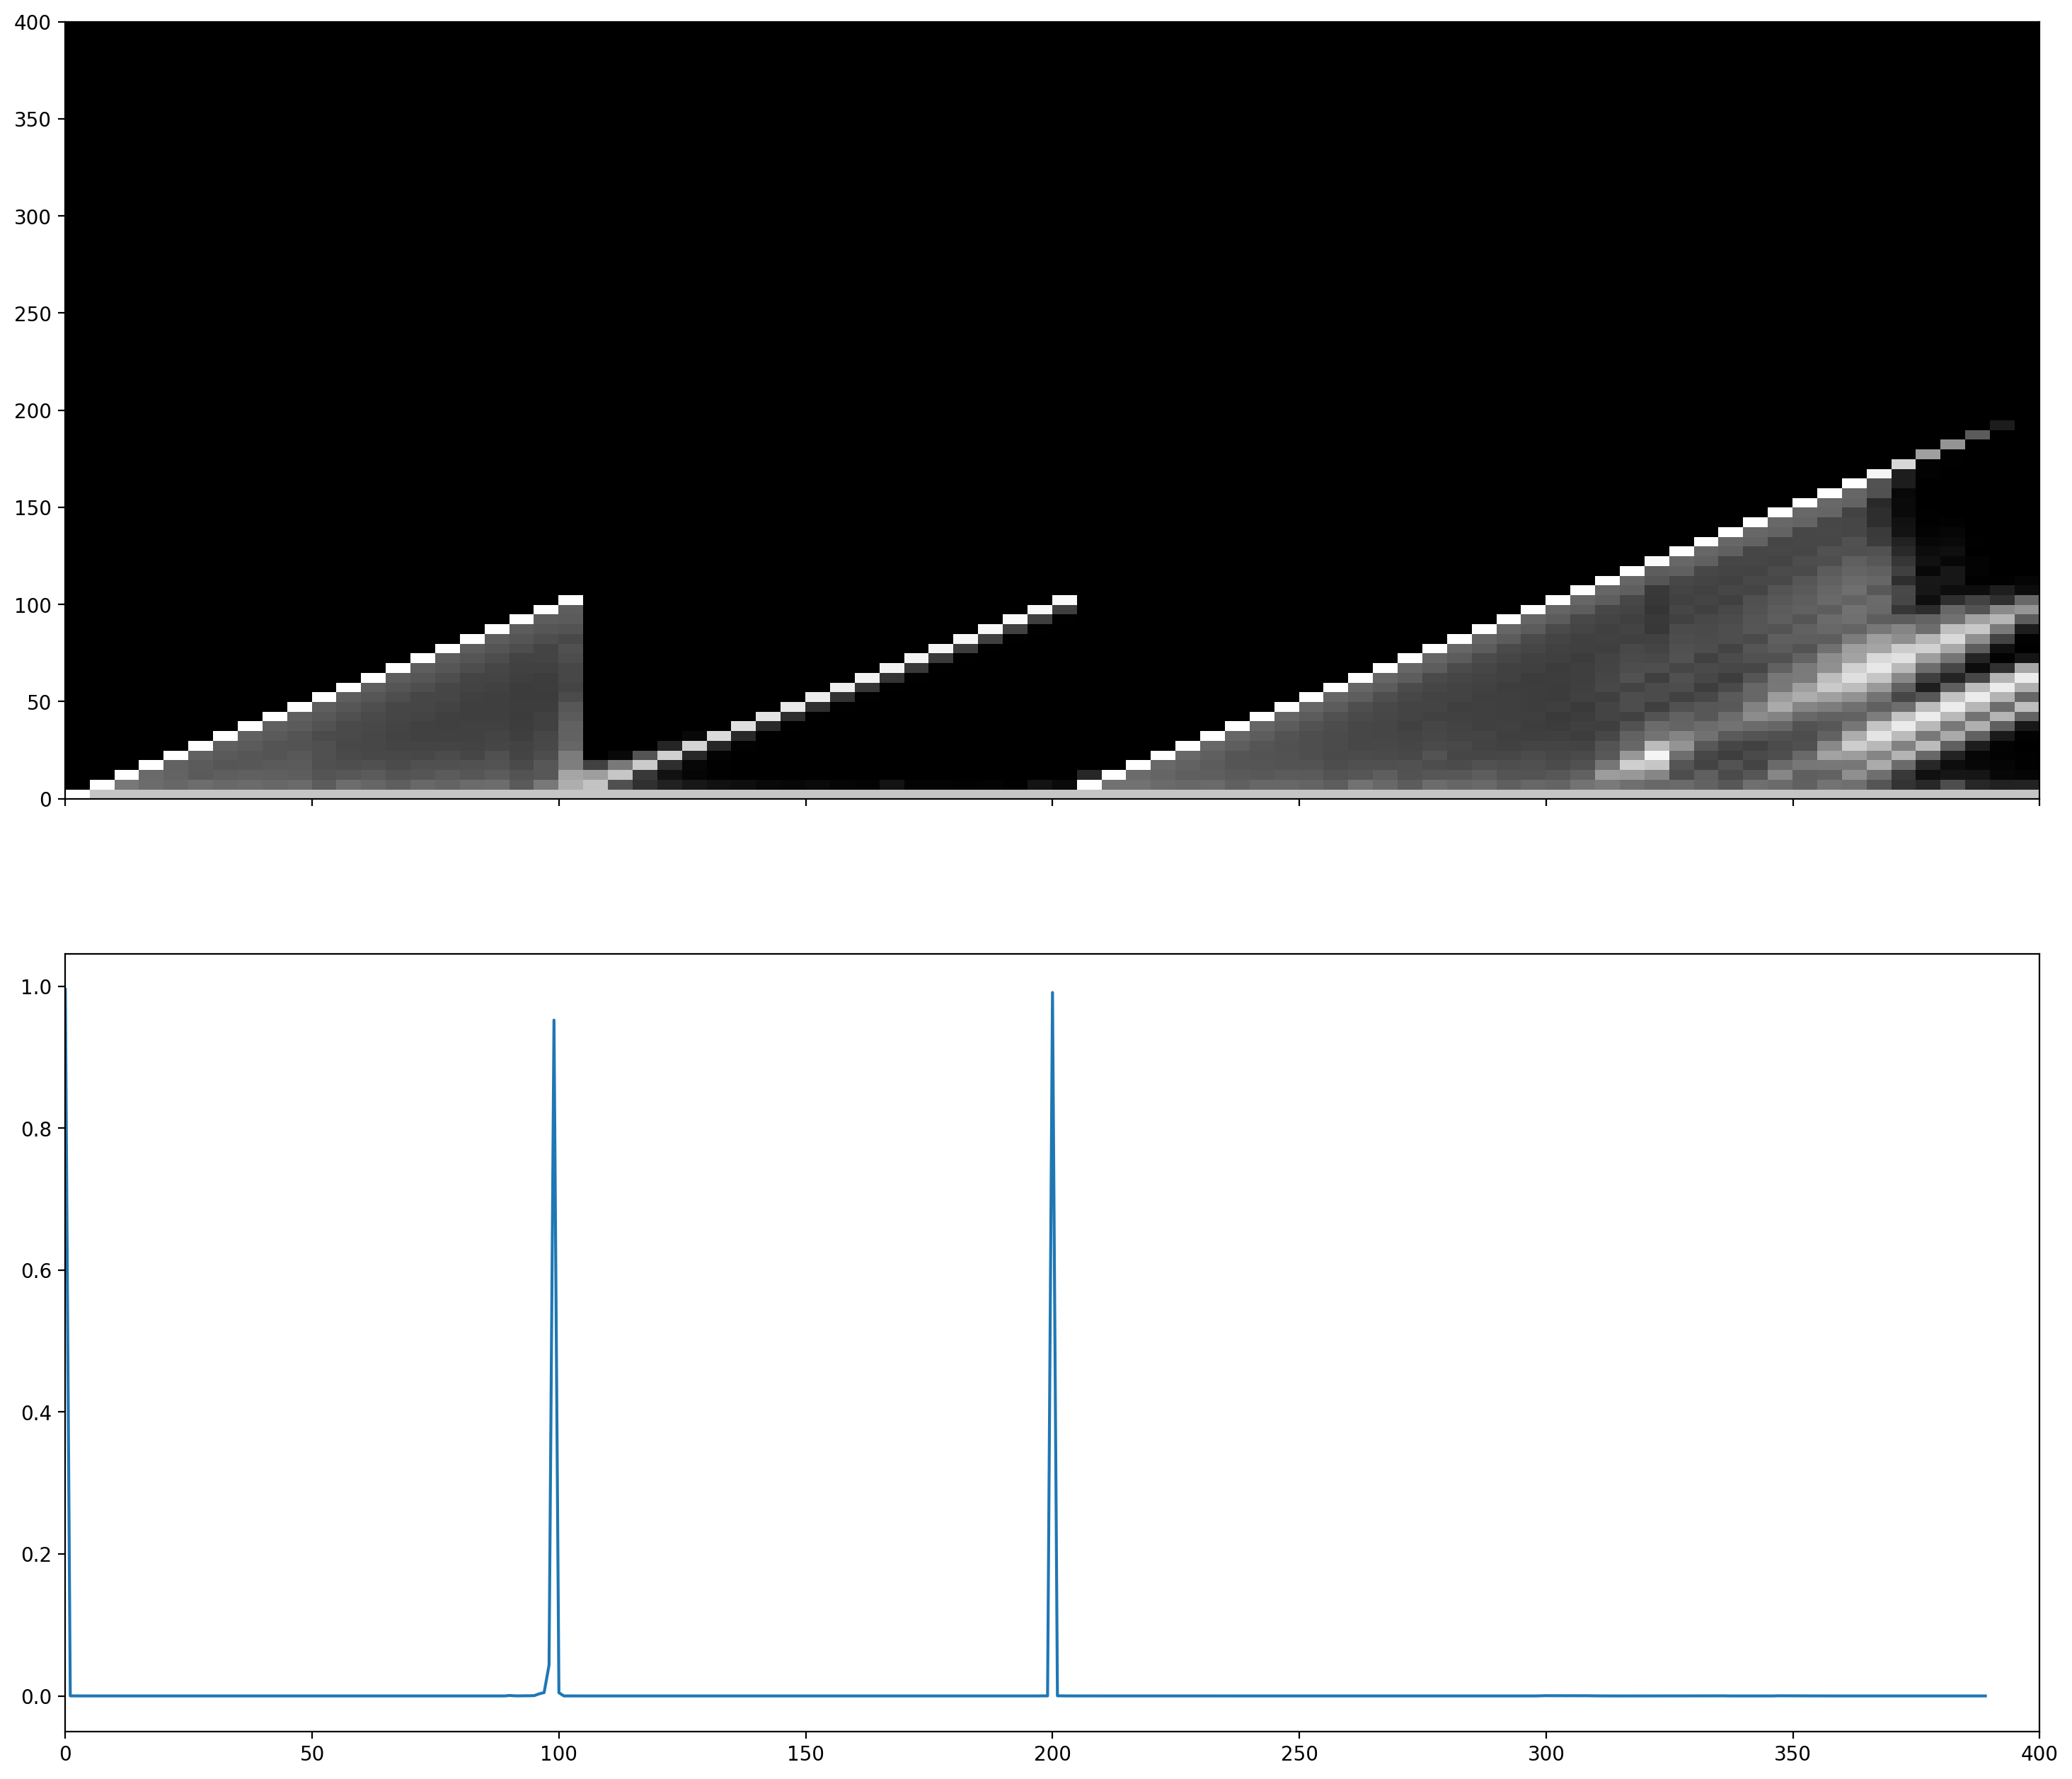

In [28]:
R, maxes = online_changepoint_detection(
    combined_current_action_time36, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True, dpi=200)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[1].plot(R[Nw,Nw:-1])

### Caso 3

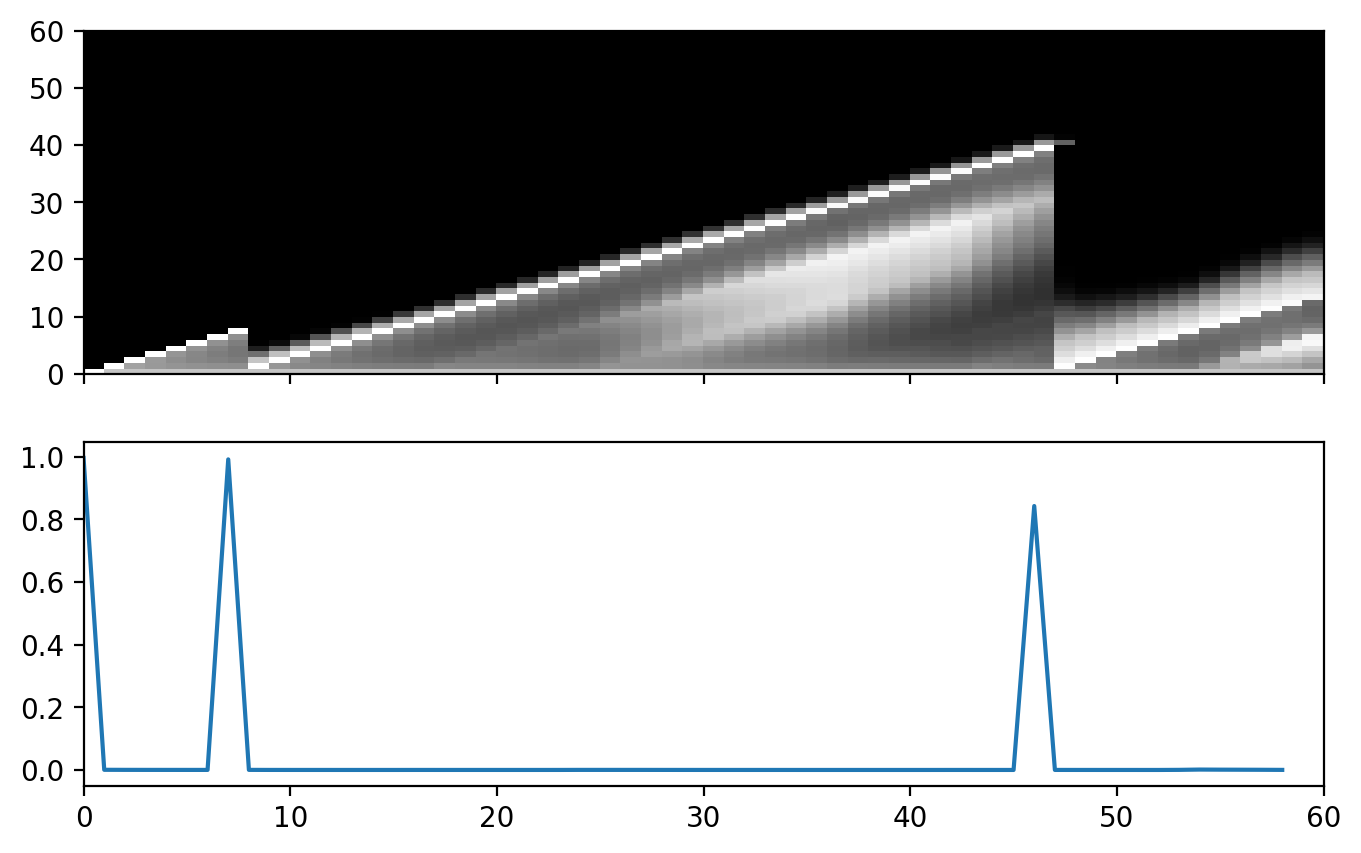

In [29]:
R, maxes = online_changepoint_detection(
    current_action_time_df_case3, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[8, 5], sharex=True, dpi=200)
sparsity = 1
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=1
ax[1].plot(R[Nw,Nw:-1])

### Caso 4

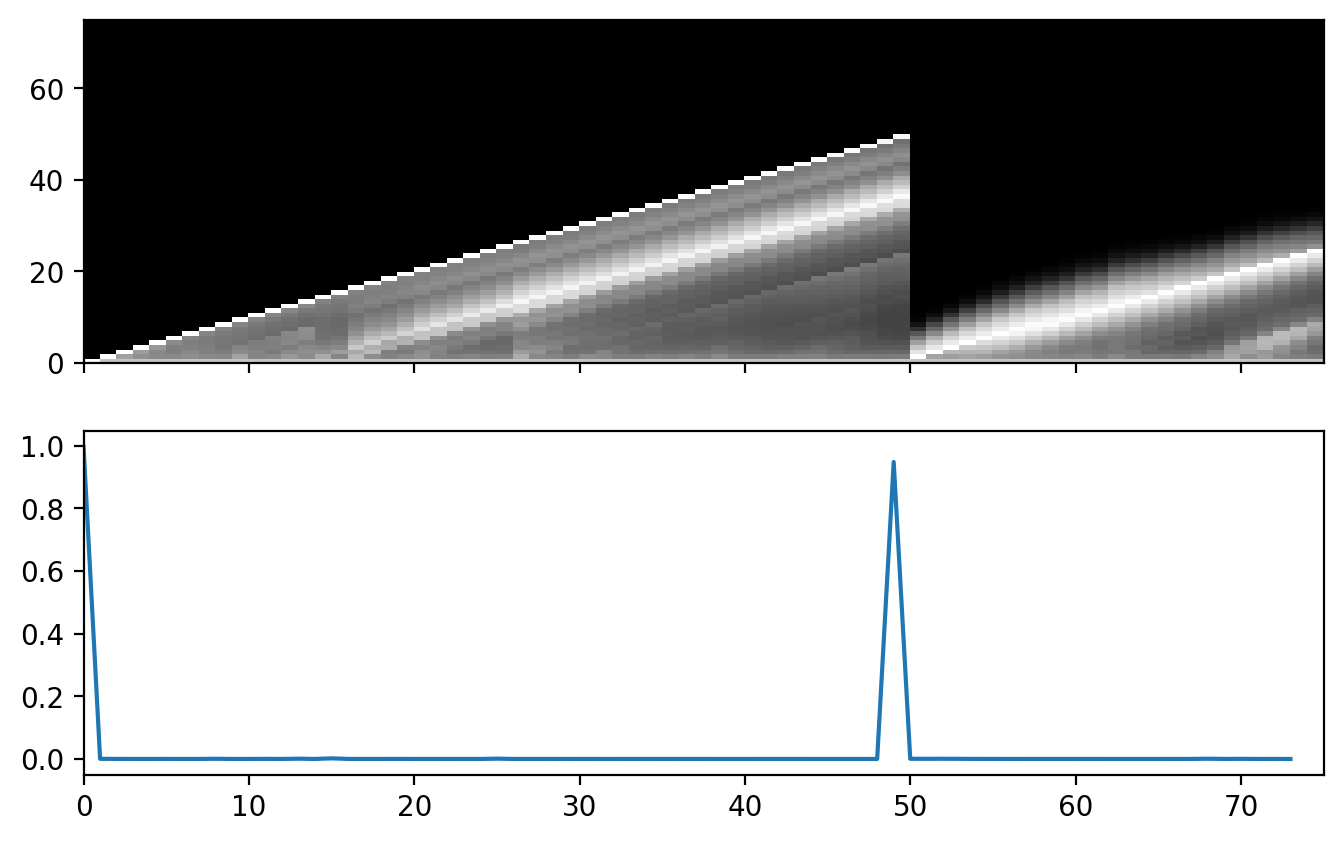

In [30]:
R, maxes = online_changepoint_detection(
    current_action_time_df_case4, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[8, 5], sharex=True, dpi=200)
sparsity = 1
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=1
ax[1].plot(R[Nw,Nw:-1])

### Caso 5

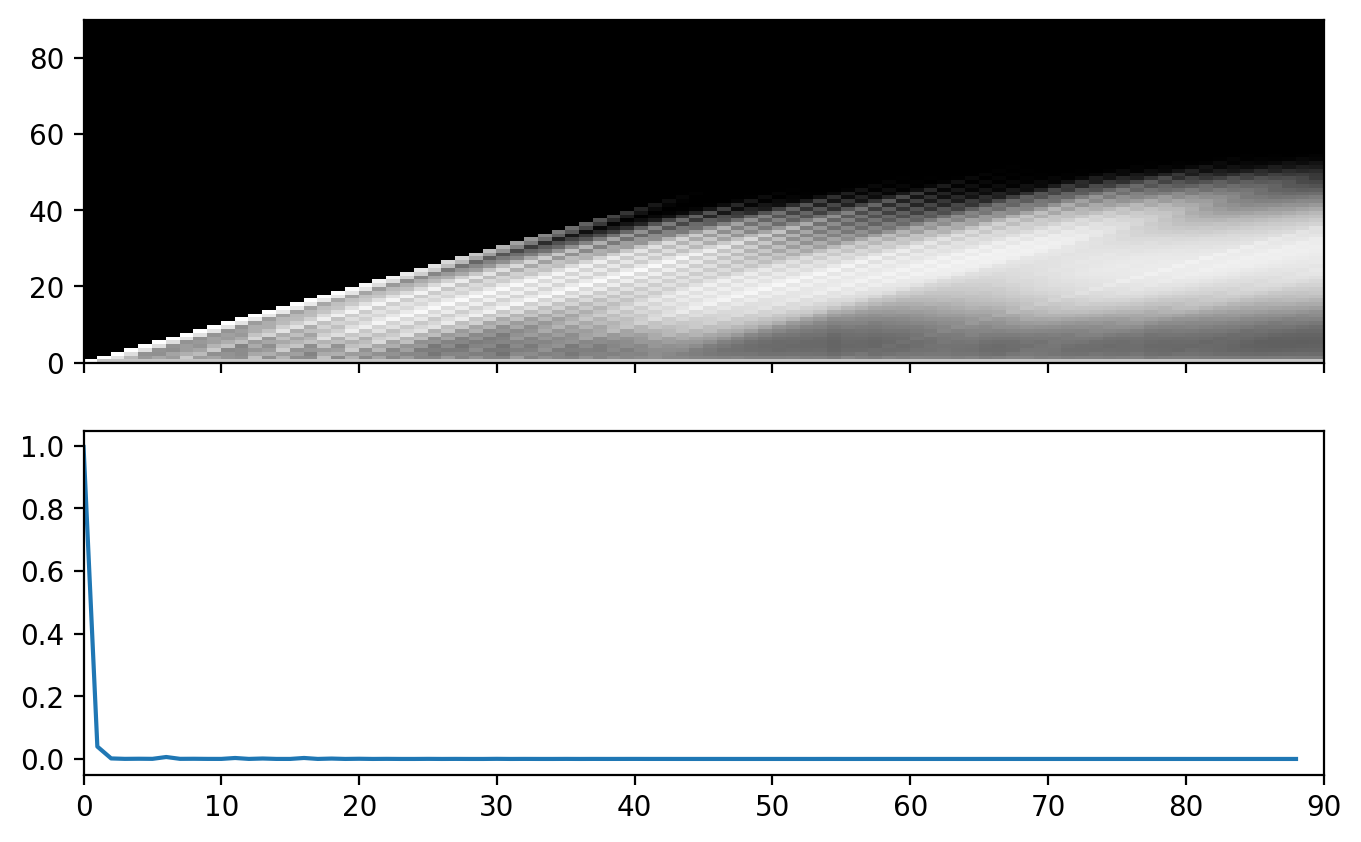

In [34]:
R, maxes = online_changepoint_detection(
    current_action_time_df_case5, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[8, 5], sharex=True, dpi=200)
sparsity = 1
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=1
ax[1].plot(R[Nw,Nw:-1])

### Caso 6

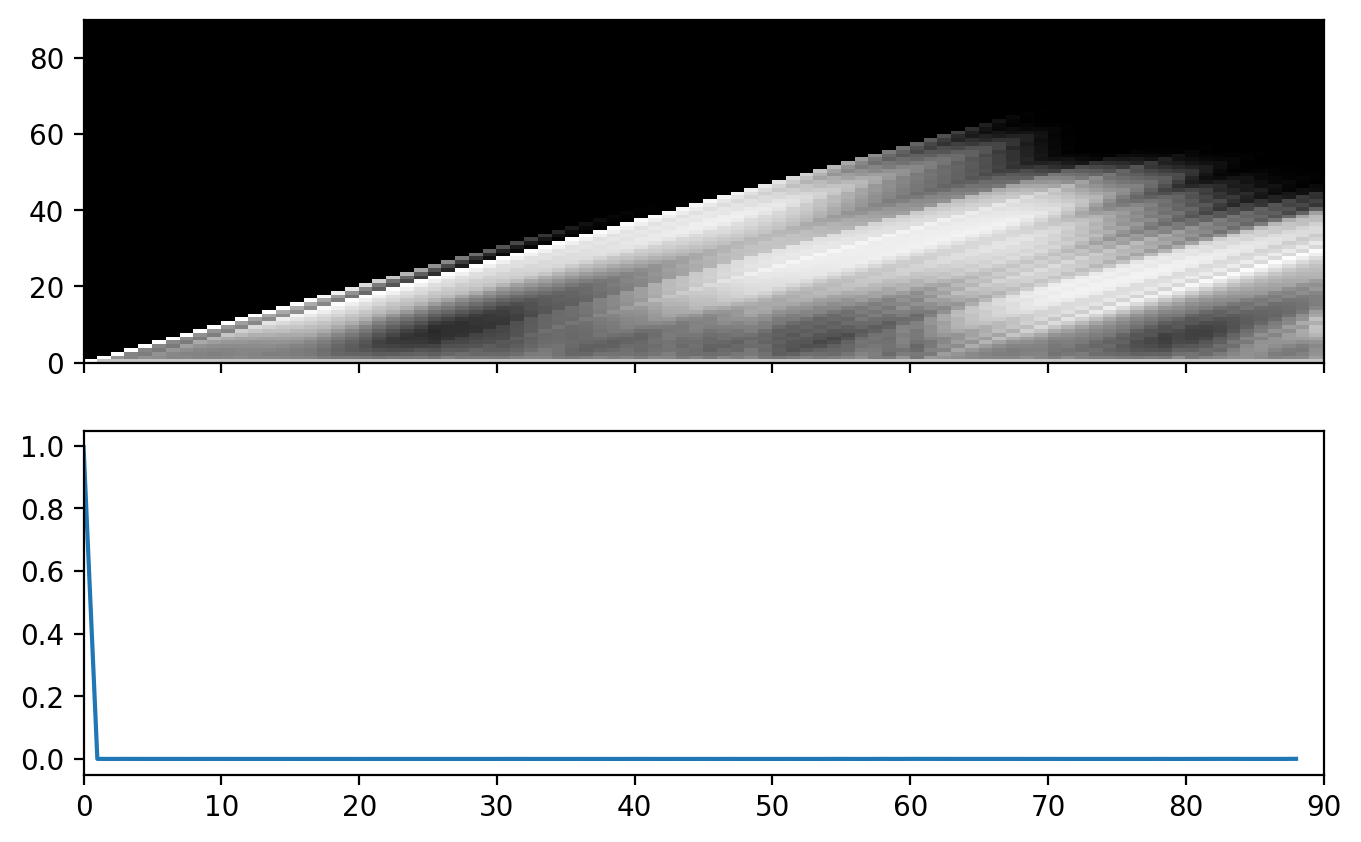

In [32]:
R, maxes = online_changepoint_detection(
    current_action_time_df_case6, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[8, 5], sharex=True, dpi=200)
sparsity = 1
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=1
ax[1].plot(R[Nw,Nw:-1])